<a href="https://colab.research.google.com/github/tanisha1112/ECE_792_Assignments/blob/main/ECE_792_HW5_GCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkx
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import glob
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import cv2
from numpy import array
import networkx as nx
from networkx import read_edgelist, set_node_attributes
from networkx import shortest_path_length
from torch.nn import Linear, Dropout
from sklearn.metrics import classification_report
from torch_geometric.data import Data

In [ ]:
karate_edge_path = '/content/drive/MyDrive/karate.edgelist.txt'
karate_attributes_path = '/content/drive/MyDrive/karate.attributes.csv'

In [ ]:
network = read_edgelist(karate_edge_path,nodetype=int)

In [ ]:
attributes = pd.read_csv(karate_attributes_path, index_col=['node'])

In [ ]:
attributes

,role,community
node,,
0,Administrator,Administrator
1,Member,Administrator
2,Member,Administrator
3,Member,Administrator
4,Member,Administrator
5,Member,Administrator
6,Member,Administrator
7,Member,Administrator
8,Member,Administrator


In [ ]:
for attribute in attributes.columns.values:
    set_node_attributes(network,values=pd.Series(attributes[attribute],index=attributes.index).to_dict(),name=attribute)

In [ ]:
X_train, y_train = map(array, zip(*[([node], data['role'] == 'Administrator') for node, data
                                    in network.nodes(data=True) if data['role'] in {'Administrator', 'Instructor'}]))

In [ ]:
X_test, y_test = map(array, zip(*[([node], data['community'] == 'Administrator') for node,
data in network.nodes(data=True) if data['role'] == 'Member']))

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_2 = np.zeros((34, 36))
node_distance_instructor = shortest_path_length(network, target=X_train[0][0])
node_distance_administrator = shortest_path_length(network, target=X_train[-1][0])

In [ ]:
for node in network.nodes():
    X_2[node][node] = 1
    X_2[node][-2] = node_distance_administrator[node]
    X_2[node][-1] = node_distance_instructor[node]

In [ ]:
A = nx.to_numpy_array(network)

In [ ]:
def degree_matrix(A):
    n = A.shape[0] # Number of vertices
    deg = np.sum(A, axis=1) # Compute vertex degrees
    D = np.diag(deg) # Construct diagonal matrix
    return D
D = degree_matrix(A)

In [ ]:
def NormLaplacian_matrix(A, D):
    n = A.shape[0]
    D_inv_sqrt = np.sqrt(np.linalg.inv(D))
    L = np.identity(n) + np.dot(np.dot(D_inv_sqrt, A), D_inv_sqrt)
    return L

In [ ]:
L = NormLaplacian_matrix(A,D)
L

array([[1.        , 0.08333333, 0.07905694, ..., 0.        , 0.        ,
        0.        ],
       [0.08333333, 1.        , 0.10540926, ..., 0.        , 0.        ,
        0.        ],
       [0.07905694, 0.10540926, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.35355339],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.35355339, 0.        ,
        1.        ]])

In [ ]:
G = nx.karate_club_graph()
labels = {node: (1 if node == 0 or node == 33 else 0) for node in G.nodes()}
train_nodes = [0, 33]
test_nodes = list(set(G.nodes()) - set(train_nodes))

In [ ]:
labels

{0: 1,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 1}

In [ ]:
edge_index = torch.tensor(np.array(list(G.edges())).T, dtype=torch.long)
x = torch.tensor(np.zeros((len(G.nodes()), 36)), dtype=torch.float)
for node in G.nodes():
    x[node][node] = 1
    x[node][-2] = nx.shortest_path_length(G, node, train_nodes[0])
    x[node][-1] = nx.shortest_path_length(G, node, train_nodes[1])

In [ ]:
data = Data(x=x, edge_index=edge_index)
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 2.],
        [0., 1., 0.,  ..., 0., 1., 2.],
        [0., 0., 1.,  ..., 0., 1., 2.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 2., 1.],
        [0., 0., 0.,  ..., 1., 2., 0.]])

In [ ]:
class GraphConvolution(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        support = torch.mm(x, self.weight)
        output = torch.spmm(adj, support)
        output = output + self.bias
        return output

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GraphConvolution(36, 8)
        self.conv2 = GraphConvolution(8, 8)
        self.conv3 = GraphConvolution(8, 2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(2, 2)
        #self.fc1 = torch.nn.Linear(2,)

    def forward(self, x, adj):
        x = self.conv1(x, adj)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, adj)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, adj)
        return self.classifier(x)

In [ ]:
L = torch.FloatTensor(L)
X_2 = torch.FloatTensor(X_2)
y_train = torch.FloatTensor(y_train).int()
X_train1 = torch.FloatTensor(X_train).int()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
X_2 = X_2.to(device)
L = L.to(device)
train_loss = []
for epoch in range(5000):
    optimizer.zero_grad()
    out = model(X_2, L)
    loss = loss_fn(out[X_train1].squeeze(), y_train.type(torch.LongTensor).to(device))
    loss.backward()
    optimizer.step()
    train_loss.append(float(loss))
    print(loss)

tensor(0.9329, grad_fn=<NllLossBackward0>)
tensor(1.0249, grad_fn=<NllLossBackward0>)
tensor(0.7771, grad_fn=<NllLossBackward0>)
tensor(0.9138, grad_fn=<NllLossBackward0>)
tensor(0.8392, grad_fn=<NllLossBackward0>)
tensor(0.6040, grad_fn=<NllLossBackward0>)
tensor(0.7630, grad_fn=<NllLossBackward0>)
tensor(0.5914, grad_fn=<NllLossBackward0>)
tensor(0.7425, grad_fn=<NllLossBackward0>)
tensor(0.5847, grad_fn=<NllLossBackward0>)
tensor(0.7685, grad_fn=<NllLossBackward0>)
tensor(0.7238, grad_fn=<NllLossBackward0>)
tensor(0.7015, grad_fn=<NllLossBackward0>)
tensor(0.6005, grad_fn=<NllLossBackward0>)
tensor(0.6342, grad_fn=<NllLossBackward0>)
tensor(0.6890, grad_fn=<NllLossBackward0>)
tensor(0.6797, grad_fn=<NllLossBackward0>)
tensor(0.7731, grad_fn=<NllLossBackward0>)
tensor(0.5304, grad_fn=<NllLossBackward0>)
tensor(0.4720, grad_fn=<NllLossBackward0>)
tensor(0.5723, grad_fn=<NllLossBackward0>)
tensor(0.4345, grad_fn=<NllLossBackward0>)
tensor(0.5293, grad_fn=<NllLossBackward0>)
tensor(0.48

In [ ]:
preds = model(X_2, L).argmax(dim=1)
preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
L

tensor([[1.0000, 0.0833, 0.0791,  ..., 0.0000, 0.0000, 0.0000],
        [0.0833, 1.0000, 0.1054,  ..., 0.0000, 0.0000, 0.0000],
        [0.0791, 0.1054, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.3536],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3536, 0.0000, 1.0000]])

In [ ]:
preds = preds[X_test.squeeze()].cpu().detach()
len(preds)

32

In [ ]:
y_test = torch.FloatTensor(y_test)

In [ ]:
test_correct = y_test == preds[X_test.squeeze()].cpu().detach()

In [ ]:
test_acc = int(test_correct.sum()) / len(X_test)
test_acc

0.81

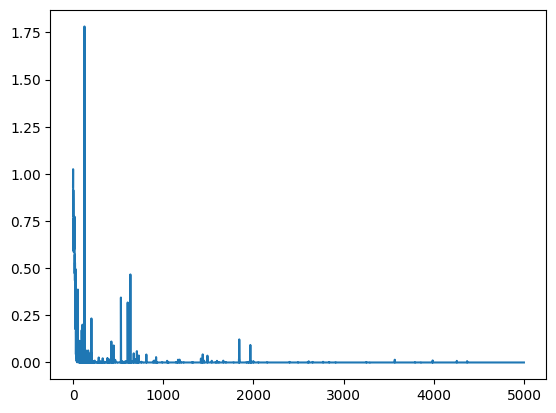

In [ ]:
plt.plot(train_loss)

In [ ]:
class GraphAttention(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphAttention, self).__init__()
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_features))
        self.a = torch.nn.Parameter(torch.FloatTensor(2*out_features, 1))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.zeros_(self.bias)
        torch.nn.init.xavier_uniform_(self.a)

    def forward(self, x, adj):
        support = torch.mm(x, self.weight)
        h = support
        # Compute attention coefficients
        N = h.size()[0]
        a_input = torch.cat([h.repeat(1, N).view(N*N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2*h.size()[-1])
        e = torch.matmul(a_input, self.a).squeeze(2)
        attention = torch.nn.functional.softmax(torch.nn.functional.leaky_relu(e), dim=1)
        # Apply attention coefficients
        h_prime = torch.matmul(attention, h)
        output = torch.spmm(adj, h_prime)
        output = output + self.bias
        return output


In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.att1 = GraphAttention(36, 8)
        self.att2 = GraphAttention(8, 8)
        self.att3 = GraphAttention(8, 2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(2, 2)

    def forward(self, x, adj):
        x = self.att1(x, adj)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.att2(x, adj)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.att3(x, adj)
        return self.classifier(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
X_2 = X_2.to(device)
L = L.to(device)
train_loss = []
for epoch in range(5000):
    optimizer.zero_grad()
    out = model(X_2, L)
    loss = loss_fn(out[X_train1].squeeze(), y_train.type(torch.LongTensor).to(device))
    loss.backward()
    optimizer.step()
    train_loss.append(float(loss))
    print(loss)

tensor(0.7819, grad_fn=<NllLossBackward0>)
tensor(0.7762, grad_fn=<NllLossBackward0>)
tensor(0.7695, grad_fn=<NllLossBackward0>)
tensor(0.7667, grad_fn=<NllLossBackward0>)
tensor(0.7612, grad_fn=<NllLossBackward0>)
tensor(0.7576, grad_fn=<NllLossBackward0>)
tensor(0.7514, grad_fn=<NllLossBackward0>)
tensor(0.7462, grad_fn=<NllLossBackward0>)
tensor(0.7415, grad_fn=<NllLossBackward0>)
tensor(0.7359, grad_fn=<NllLossBackward0>)
tensor(0.7314, grad_fn=<NllLossBackward0>)
tensor(0.7274, grad_fn=<NllLossBackward0>)
tensor(0.7234, grad_fn=<NllLossBackward0>)
tensor(0.7188, grad_fn=<NllLossBackward0>)
tensor(0.7150, grad_fn=<NllLossBackward0>)
tensor(0.7108, grad_fn=<NllLossBackward0>)
tensor(0.7082, grad_fn=<NllLossBackward0>)
tensor(0.7018, grad_fn=<NllLossBackward0>)
tensor(0.6986, grad_fn=<NllLossBackward0>)
tensor(0.6890, grad_fn=<NllLossBackward0>)
tensor(0.6774, grad_fn=<NllLossBackward0>)
tensor(0.6638, grad_fn=<NllLossBackward0>)
tensor(0.6591, grad_fn=<NllLossBackward0>)
tensor(0.66

In [ ]:
preds = model(X_2, L).argmax(dim=1)

In [ ]:
preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
preds = preds[X_test.squeeze()].cpu().detach()


In [ ]:
len(X_test)

32

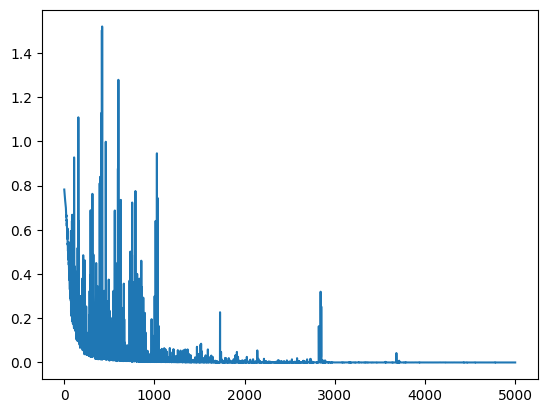

In [ ]:
plt.plot(train_loss)